<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_LSTM/CNN_LSTM_EURCHF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 5.51 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 15:23:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'EURCHF'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 97 kB 8.2 MB/s 
     |████████████████████████████████| 138 kB 66.1 MB/s 
     |████████████████████████████████| 170 kB 64.5 MB/s 
     |████████████████████████████████| 133 kB 57.4 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 62 kB 975 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(LSTM(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: ergji0a7
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_LSTM/sweeps/ergji0a7


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: raujbmd1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
16/16 [==============================] - 36s 79ms/step - loss: 0.1442 - mean_squared_error: 0.1442 - mean_absolute_error: 0.3033 - val_loss: 0.0372 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1520
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0719 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1360
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0462 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1273
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0476 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1240
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0060 - mean_squared_err

epoch,53
loss,0.00236
mean_squared_error,0.00236
mean_absolute_error,0.02499
val_loss,0.00718
val_mean_squared_error,0.00718
val_mean_absolute_error,0.05985
_runtime,52
_timestamp,1626881096
_step,53
best_val_loss,0.0065


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: u1qbsxww with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 62ms/step - loss: 0.0740 - mean_squared_error: 0.0740 - mean_absolute_error: 0.2083 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1362
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0811 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1192
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0486 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1060
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0403 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0969
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.

epoch,49
loss,0.00217
mean_squared_error,0.00217
mean_absolute_error,0.02334
val_loss,0.00445
val_mean_squared_error,0.00445
val_mean_absolute_error,0.05032
_runtime,16
_timestamp,1626881134
_step,49
best_val_loss,0.00431


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: yawml0c9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 114ms/step - loss: 0.2275 - mean_squared_error: 0.2275 - mean_absolute_error: 0.3652 - val_loss: 0.0434 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1611
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0724 - val_loss: 0.0341 - val_mean_squared_error: 0.0341 - val_mean_absolute_error: 0.1408
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0668 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1084
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0425 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1036
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066

epoch,24
loss,0.00329
mean_squared_error,0.00329
mean_absolute_error,0.03713
val_loss,0.00851
val_mean_squared_error,0.00851
val_mean_absolute_error,0.06813
_runtime,9
_timestamp,1626881150
_step,24
best_val_loss,0.00774


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▃▁▂▃▂▂▂▂▂▁▁▂▂▂▂▁▁▁▂▁
val_loss,█▆▃▃▃▂▃▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▂▂▁
val_mean_squared_error,█▆▃▃▃▂▃▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▂▂▁
val_mean_absolute_error,█▇▄▄▄▃▄▆▃▄▂▂▂▁▁▂▁▂▂▁▁▁▂▂▁
_runtime,▁▁▁▁▁▅▅▅▅▅▅▅▅▅███████████
_timestamp,▁▁▁▁▁▅▅▅▅▅▅▅▅▅███████████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: km1ok4mk with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 4s 43ms/step - loss: 0.1187 - mean_squared_error: 0.1187 - mean_absolute_error: 0.2668 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1401
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0721 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1365
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0524 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1294
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0435 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1253
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_squared_erro

epoch,199
loss,0.00223
mean_squared_error,0.00223
mean_absolute_error,0.02124
val_loss,0.00535
val_mean_squared_error,0.00535
val_mean_absolute_error,0.05498
_runtime,52
_timestamp,1626881210
_step,199
best_val_loss,0.00535


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: t98eui0c with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 61ms/step - loss: 0.1526 - mean_squared_error: 0.1526 - mean_absolute_error: 0.2723 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1349
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0715 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1030
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0648 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0837
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0567 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0977
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0108 - mean_squared_error: 0

epoch,23
loss,0.00265
mean_squared_error,0.00265
mean_absolute_error,0.03044
val_loss,0.00882
val_mean_squared_error,0.00882
val_mean_absolute_error,0.06912
_runtime,11
_timestamp,1626881231
_step,23
best_val_loss,0.00815


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▄▁▃▁▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁
val_loss,█▄▃▄▃▁▂▁▁▁▁▂▂▁▄▂▂▃▁▂▁▂▄▁
val_mean_squared_error,█▄▃▄▃▁▂▁▁▁▁▂▂▁▄▂▂▃▁▂▁▂▄▁
val_mean_absolute_error,█▅▃▄▃▁▂▂▂▂▁▂▂▁▄▂▂▃▁▂▂▂▄▁
_runtime,▁▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆████
_timestamp,▁▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆████
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: 0i2xneqm with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 4s 32ms/step - loss: 0.0615 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1767 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1275
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0583 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1081
Epoch 3/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0395 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0925
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0345 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0801
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_squared_erro

epoch,71
loss,0.0025
mean_squared_error,0.0025
mean_absolute_error,0.02871
val_loss,0.00412
val_mean_squared_error,0.00412
val_mean_absolute_error,0.0504
_runtime,26
_timestamp,1626881265
_step,71
best_val_loss,0.00377


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: lflgpduf with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 3s 32ms/step - loss: 0.2802 - mean_squared_error: 0.2802 - mean_absolute_error: 0.4753 - val_loss: 0.0495 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1680
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.1428 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1645
Epoch 3/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0950 - val_loss: 0.0371 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1671
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0885 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1642
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0140 - mean_squared_erro

epoch,199
loss,0.00465
mean_squared_error,0.00465
mean_absolute_error,0.03341
val_loss,0.01489
val_mean_squared_error,0.01489
val_mean_absolute_error,0.0961
_runtime,59
_timestamp,1626881333
_step,199
best_val_loss,0.01489


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: e3okxx1y with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 3s 31ms/step - loss: 0.0547 - mean_squared_error: 0.0547 - mean_absolute_error: 0.1523 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1125
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0805 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1348
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0877 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0945
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0631 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1008
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0086 - mean_squared_error: 0.

epoch,49
loss,0.00257
mean_squared_error,0.00257
mean_absolute_error,0.02853
val_loss,0.00424
val_mean_squared_error,0.00424
val_mean_absolute_error,0.04975
_runtime,18
_timestamp,1626881360
_step,49
best_val_loss,0.00398


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▄▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▄▅▂▂▂▃▂▂▂▁▁▁▂▁▁▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▄▅▂▂▂▃▂▂▂▁▁▁▂▁▁▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▅▅▃▂▃▄▂▂▂▂▂▂▃▂▁▂▃▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: nzhwj6fb with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 4s 60ms/step - loss: 0.1902 - mean_squared_error: 0.1902 - mean_absolute_error: 0.2882 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1366
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0942 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1257
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.0966 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1093
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.0867 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1051
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0132 - mean_squared_erro

epoch,47
loss,0.00368
mean_squared_error,0.00368
mean_absolute_error,0.03633
val_loss,0.00593
val_mean_squared_error,0.00593
val_mean_absolute_error,0.06053
_runtime,14
_timestamp,1626881384
_step,47
best_val_loss,0.00418


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▄▄▄▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▄▅▄▃▃▄▃▂▃▂▃▂▃▂▂▂▁▁▂▁▃▁▂▂▂▁▁▁▂▂▁▁▁▁▁▂
val_mean_squared_error,█▇▅▅▄▅▄▃▃▄▃▂▃▂▃▂▃▂▂▂▁▁▂▁▃▁▂▂▂▁▁▁▂▂▁▁▁▁▁▂
val_mean_absolute_error,█▇▆▅▅▅▄▃▃▄▄▂▄▃▃▂▄▂▂▃▂▂▂▁▄▂▃▂▂▁▂▁▃▂▂▁▂▂▁▂
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uwty1e0a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 4s 63ms/step - loss: 0.8795 - mean_squared_error: 0.8795 - mean_absolute_error: 0.5371 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1278
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0481 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1431
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - mean_absolute_error: 0.1089 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1343
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0978 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1091
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0138 - mean_squared_erro

epoch,38
loss,0.00462
mean_squared_error,0.00462
mean_absolute_error,0.04645
val_loss,0.01191
val_mean_squared_error,0.01191
val_mean_absolute_error,0.08386
_runtime,13
_timestamp,1626881406
_step,38
best_val_loss,0.01149


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▇▄▇▄▃▆▁▃▂▂▄▃▂▂▁▂▃▃▁▁▁▃▂▂▁▃▁▁▁▂▁▁▂▃▅▂▁
val_mean_squared_error,▅█▇▄▇▄▃▆▁▃▂▂▄▃▂▂▁▂▃▃▁▁▁▃▂▂▁▃▁▁▁▂▁▁▂▃▅▂▁
val_mean_absolute_error,▆█▇▄█▄▄▇▂▄▁▂▅▄▂▂▁▁▃▃▁▁▁▃▂▂▂▅▁▂▂▂▂▁▂▃▅▂▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jcgb1o6a with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 67ms/step - loss: 1.0315 - mean_squared_error: 1.0315 - mean_absolute_error: 0.7208 - val_loss: 0.3186 - val_mean_squared_error: 0.3186 - val_mean_absolute_error: 0.4124
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0362 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1532 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1458
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0631 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1083
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0454 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0873
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_squared_error: 0.

epoch,49
loss,0.00249
mean_squared_error,0.00249
mean_absolute_error,0.02746
val_loss,0.00433
val_mean_squared_error,0.00433
val_mean_absolute_error,0.05255
_runtime,17
_timestamp,1626881432
_step,49
best_val_loss,0.00393


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: m1kcfw40 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 60ms/step - loss: 0.1037 - mean_squared_error: 0.1037 - mean_absolute_error: 0.2069 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1337
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0402 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1211
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0362 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0928
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0394 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0839
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_err

epoch,49
loss,0.00227
mean_squared_error,0.00227
mean_absolute_error,0.02593
val_loss,0.00605
val_mean_squared_error,0.00605
val_mean_absolute_error,0.05679
_runtime,17
_timestamp,1626881459
_step,49
best_val_loss,0.00569


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▄▂▃▂▄▁▃▂▂▃▂▂▃▁▂▂▁▁▂▂▁▂▂▁▁▁▂▁▂▁▁▁▁▁▂▁
val_loss,█▇▄▃▃▂▃▂▂▂▂▂▃▁▁▁▁▁▂▂▂▁▃▁▁▂▁▂▁▁▁▁▂▁▁▂▁▁▁▁
val_mean_squared_error,█▇▄▃▃▂▃▂▂▂▂▂▃▁▁▁▁▁▂▂▂▁▃▁▁▂▁▂▁▁▁▁▂▁▁▂▁▁▁▁
val_mean_absolute_error,█▇▄▄▃▂▃▂▂▂▂▂▃▂▁▁▂▁▂▁▂▁▃▁▁▂▁▂▁▂▁▁▂▁▁▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: on41w73a with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 4s 135ms/step - loss: 3.5271 - mean_squared_error: 3.5271 - mean_absolute_error: 1.2810 - val_loss: 0.0618 - val_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.1931
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - mean_absolute_error: 0.1541 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1630
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0546 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1708
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1567 - val_loss: 0.0622 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.2039
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0471 - mean_squared_error: 0.0

epoch,37
loss,0.05939
mean_squared_error,0.05939
mean_absolute_error,0.12699
val_loss,0.01473
val_mean_squared_error,0.01473
val_mean_absolute_error,0.10004
_runtime,13
_timestamp,1626881491
_step,37
best_val_loss,0.00692


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,█▅▆█▅▄▅▄▃▂▄▂▂▂▂▆▂▄▃▃▃▂▂▁▂▁▂▁▂▁▂▂▂▁▂▁▂▂
val_mean_squared_error,█▅▆█▅▄▅▄▃▂▄▂▂▂▂▆▂▄▃▃▃▂▂▁▂▁▂▁▂▁▂▂▂▁▂▁▂▂
val_mean_absolute_error,▇▆▆█▆▅▆▅▄▃▅▃▃▃▂▇▃▅▄▃▄▂▃▂▃▂▃▁▂▂▂▂▂▂▃▂▃▃
_runtime,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆█
_timestamp,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dk7pufki with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 3s 117ms/step - loss: 0.3175 - mean_squared_error: 0.3175 - mean_absolute_error: 0.5091 - val_loss: 0.0706 - val_mean_squared_error: 0.0706 - val_mean_absolute_error: 0.2026
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0666 - mean_squared_error: 0.0666 - mean_absolute_error: 0.1968 - val_loss: 0.0651 - val_mean_squared_error: 0.0651 - val_mean_absolute_error: 0.2243
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.1584 - val_loss: 0.0828 - val_mean_squared_error: 0.0828 - val_mean_absolute_error: 0.2509
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.1555 - val_loss: 0.0540 - val_mean_squared_error: 0.0540 - val_mean_absolute_error: 0.2049
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0203 - mean_squared_error: 0.020

epoch,199
loss,0.0046
mean_squared_error,0.0046
mean_absolute_error,0.03093
val_loss,0.01441
val_mean_squared_error,0.01441
val_mean_absolute_error,0.09326
_runtime,30
_timestamp,1626881540
_step,199
best_val_loss,0.01441


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: i7drgfn3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 4s 132ms/step - loss: 0.7344 - mean_squared_error: 0.7344 - mean_absolute_error: 0.5671 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1297
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0994 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1444
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.1001 - val_loss: 0.0312 - val_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.1430
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0978 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1356
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0109 - mean_squared_error: 0.0109 -

epoch,49
loss,0.00264
mean_squared_error,0.00264
mean_absolute_error,0.02945
val_loss,0.0041
val_mean_squared_error,0.0041
val_mean_absolute_error,0.04823
_runtime,14
_timestamp,1626881565
_step,49
best_val_loss,0.0041


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆██▇▅▄▆▆▃▄▃▂▂▂▃▄▂▂▃▂▂▂▃▂▂▂▃▂▁▁▁▂▂▁▂▁▁▁▁▁
val_mean_squared_error,▆██▇▅▄▆▆▃▄▃▂▂▂▃▄▂▂▃▂▂▂▃▂▂▂▃▂▁▁▁▂▂▁▂▁▁▁▁▁
val_mean_absolute_error,▇██▇▆▅▆▆▃▅▄▃▃▂▄▅▂▂▃▂▂▃▃▂▂▂▃▂▂▁▁▂▃▁▂▁▂▂▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██████
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6xwo2ygu with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 4s 34ms/step - loss: 0.0744 - mean_squared_error: 0.0744 - mean_absolute_error: 0.1503 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1206
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0641 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0961
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0600 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0906
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0448 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0841
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0078 - mean_squared_error: 0.

epoch,49
loss,0.00237
mean_squared_error,0.00237
mean_absolute_error,0.02559
val_loss,0.00467
val_mean_squared_error,0.00467
val_mean_absolute_error,0.05107
_runtime,24
_timestamp,1626881599
_step,49
best_val_loss,0.00402


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▃▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▃▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▅▃▄▃▂▄▃▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▃▂▃▄▂▅▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▃▃▂▃▄▂▅▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▃▃▃▄▂▆▂▂▃▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ee8uomdj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 4s 35ms/step - loss: 0.1128 - mean_squared_error: 0.1128 - mean_absolute_error: 0.2463 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1372
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0499 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1301
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0399 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1154
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0388 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1000
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_squared_erro

epoch,55
loss,0.00238
mean_squared_error,0.00238
mean_absolute_error,0.02716
val_loss,0.00671
val_mean_squared_error,0.00671
val_mean_absolute_error,0.05894
_runtime,24
_timestamp,1626881633
_step,55
best_val_loss,0.00607


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: l8znpeo4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 119ms/step - loss: 0.1371 - mean_squared_error: 0.1371 - mean_absolute_error: 0.2530 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1397
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0661 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1341
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error: 0.1102 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1305
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0600 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1209
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0158 - mean_squared_error: 0.015

epoch,36
loss,0.0034
mean_squared_error,0.0034
mean_absolute_error,0.03994
val_loss,0.01344
val_mean_squared_error,0.01344
val_mean_absolute_error,0.08194
_runtime,12
_timestamp,1626881656
_step,36
best_val_loss,0.01031


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▇▃▅▄▅▄▄▄▃▄▃▂▄▃▄▃▃▂▃▂▃▁▃▂▂▃▂▂▂▂▂▂▂▂▁
val_loss,▇▇▇▆▇▅▄▆▄█▂▃▇▂▅▄▃▃▃▂▄▁▂▅▁▂▁▁▁▂▁▁▁▅▁▂▂
val_mean_squared_error,▇▇▇▆▇▅▄▆▄█▂▃▇▂▅▄▃▃▃▂▄▁▂▅▁▂▁▁▁▂▁▁▁▅▁▂▂
val_mean_absolute_error,█▇▇▆▆▅▄▆▄▇▃▄█▂▄▃▂▃▃▂▄▁▂▆▂▃▁▂▂▃▂▂▁▅▁▂▂
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆███████████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆███████████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0gb80d9f with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 4s 128ms/step - loss: 3.1233 - mean_squared_error: 3.1233 - mean_absolute_error: 1.1214 - val_loss: 0.0434 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1692
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0593 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1635
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0551 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1615
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1734 - val_loss: 0.0715 - val_mean_squared_error: 0.0715 - val_mean_absolute_error: 0.2215
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0932 - mean_squared_error: 0.0932 - 

epoch,29
loss,0.00736
mean_squared_error,0.00736
mean_absolute_error,0.05893
val_loss,0.02423
val_mean_squared_error,0.02423
val_mean_absolute_error,0.12478
_runtime,12
_timestamp,1626881680
_step,29
best_val_loss,0.0104


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▂▃▂▂▂▂▂▁▂▁▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,▃▃▃▅▅▃▂▂▂▄▃▆▂▃▂▁▁▄▁▁▄▁▂▁▂▁█▁▁▂
val_mean_squared_error,▃▃▃▅▅▃▂▂▂▄▃▆▂▃▂▁▁▄▁▁▄▁▂▁▂▁█▁▁▂
val_mean_absolute_error,▄▄▃▅▅▃▃▃▂▄▃▆▂▃▃▂▁▅▁▁▄▂▂▁▂▁█▁▁▂
_runtime,▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆█████
_timestamp,▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆█████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: k6vkflzv with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 3s 133ms/step - loss: 0.3090 - mean_squared_error: 0.3090 - mean_absolute_error: 0.5111 - val_loss: 0.1828 - val_mean_squared_error: 0.1828 - val_mean_absolute_error: 0.3480
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.2408 - mean_squared_error: 0.2408 - mean_absolute_error: 0.4413 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - val_mean_absolute_error: 0.2687
Epoch 3/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1535 - mean_squared_error: 0.1535 - mean_absolute_error: 0.3395 - val_loss: 0.0783 - val_mean_squared_error: 0.0783 - val_mean_absolute_error: 0.2123
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1022 - mean_squared_error: 0.1022 - mean_absolute_error: 0.2597 - val_loss: 0.0552 - val_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.1803
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0583 - mean_squared_error: 0.058

epoch,15
loss,0.02219
mean_squared_error,0.02219
mean_absolute_error,0.12835
val_loss,0.04993
val_mean_squared_error,0.04993
val_mean_absolute_error,0.19725
_runtime,10
_timestamp,1626881700
_step,15
best_val_loss,0.04633


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▁▁▁▂▂▂▂▂▂▂▂▂▂
_runtime,▁▁▁▁▁███████████
_timestamp,▁▁▁▁▁███████████
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: 2nljeudu with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 4s 33ms/step - loss: 0.4252 - mean_squared_error: 0.4252 - mean_absolute_error: 0.4749 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1513
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - mean_absolute_error: 0.0993 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1120
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0641 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1007
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0468 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0827
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_erro

epoch,50
loss,0.002
mean_squared_error,0.002
mean_absolute_error,0.0211
val_loss,0.00377
val_mean_squared_error,0.00377
val_mean_absolute_error,0.04721
_runtime,22
_timestamp,1626881733
_step,50
best_val_loss,0.00355


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▃▃▂▂▂▂▂▁▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: u1s6ketc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 5s 68ms/step - loss: 0.1108 - mean_squared_error: 0.1108 - mean_absolute_error: 0.2210 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1330
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0456 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1151
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0356 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1076
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0442 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0879
Epoch 5/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0058 - mean_squared_e

epoch,42
loss,0.00224
mean_squared_error,0.00224
mean_absolute_error,0.02539
val_loss,0.0065
val_mean_squared_error,0.0065
val_mean_absolute_error,0.06047
_runtime,18
_timestamp,1626881776
_step,42
best_val_loss,0.00641


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▂▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▃▃▂▂▃▂▂▃▂▂▁▁▃▂▁▁▂▁▂▂▁▂▁▂▁▁▂▁▁▂▂▁▁▁▁
val_loss,█▆▆▄▃▃▃▂▂▂▂▄▂▂▁▂▂▃▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▄▃▃▃▂▂▂▂▄▂▂▁▂▂▃▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▄▃▃▃▃▂▂▂▄▂▂▁▁▂▃▁▁▂▁▁▃▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: 6v2dgxog with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 4s 131ms/step - loss: 3.1040 - mean_squared_error: 3.1040 - mean_absolute_error: 1.0538 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1693
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0606 - val_loss: 0.0683 - val_mean_squared_error: 0.0683 - val_mean_absolute_error: 0.2115
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1942 - val_loss: 0.0553 - val_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.1884
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0640 - mean_squared_error: 0.0640 - mean_absolute_error: 0.2116 - val_loss: 0.0661 - val_mean_squared_error: 0.0661 - val_mean_absolute_error: 0.2119
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0448 - mean_squared_error: 0.0448

epoch,38
loss,0.00884
mean_squared_error,0.00884
mean_absolute_error,0.06953
val_loss,0.01022
val_mean_squared_error,0.01022
val_mean_absolute_error,0.08031
_runtime,13
_timestamp,1626881801
_step,38
best_val_loss,0.00864


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▃▃▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▆█▆▇▆▃█▂▄▄▂▂▂▂▂▅▁▅▂▁▂▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▅█▆█▆▇▆▃█▂▄▄▂▂▂▂▂▅▁▅▂▁▂▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▅▇▆▇▆▇▆▄█▃▄▅▃▃▃▃▂▅▂▆▂▂▂▁▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆███
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8cev61ow with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 93ms/step - loss: 0.1263 - mean_squared_error: 0.1263 - mean_absolute_error: 0.2764 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1347
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0884 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1432
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0540 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1274
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0420 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1206
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_squared_erro

epoch,51
loss,0.0023
mean_squared_error,0.0023
mean_absolute_error,0.0269
val_loss,0.00647
val_mean_squared_error,0.00647
val_mean_absolute_error,0.05656
_runtime,17
_timestamp,1626881832
_step,51
best_val_loss,0.0055


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▆▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mhkfylpw with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 66ms/step - loss: 0.6968 - mean_squared_error: 0.6968 - mean_absolute_error: 0.4626 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1499
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0773 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1412
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.1042 - val_loss: 0.0297 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1334
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - mean_absolute_error: 0.0980 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1014
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0079 - mean_squared_error

epoch,33
loss,0.00601
mean_squared_error,0.00601
mean_absolute_error,0.05191
val_loss,0.01013
val_mean_squared_error,0.01013
val_mean_absolute_error,0.08454
_runtime,16
_timestamp,1626881867
_step,33
best_val_loss,0.0046


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▂▁█▅▂▂▂▂▂▂▂
val_loss,██▇▄▄▂▇▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▂▁▃█▆▄▄▃▃▃▂▂
val_mean_squared_error,██▇▄▄▂▇▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▂▁▃█▆▄▄▃▃▃▂▂
val_mean_absolute_error,█▇▇▄▅▃█▂▂▂▂▃▂▂▁▂▃▁▁▁▂▂▃▁▄█▇▅▅▄▄▄▃▃
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: liwzcr6o with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 62ms/step - loss: 0.5483 - mean_squared_error: 0.5483 - mean_absolute_error: 0.5681 - val_loss: 0.1036 - val_mean_squared_error: 0.1036 - val_mean_absolute_error: 0.2529
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0303 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1384 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1431
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0757 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1155
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0555 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1097
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0080 - mean_squared_erro

epoch,76
loss,0.00239
mean_squared_error,0.00239
mean_absolute_error,0.02739
val_loss,0.00389
val_mean_squared_error,0.00389
val_mean_absolute_error,0.04791
_runtime,21
_timestamp,1626881902
_step,76
best_val_loss,0.00362


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nxhbycdy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 5s 37ms/step - loss: 0.0712 - mean_squared_error: 0.0712 - mean_absolute_error: 0.1549 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1282
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0840 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0799
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0729 - val_loss: 0.0325 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1586
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0716 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0691
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_err

epoch,21
loss,0.00265
mean_squared_error,0.00265
mean_absolute_error,0.02792
val_loss,0.01005
val_mean_squared_error,0.01005
val_mean_absolute_error,0.07555
_runtime,18
_timestamp,1626881932
_step,21
best_val_loss,0.00818


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▃▃▃▄▂▃▂▁▃▂▂▁▂▂▁▁▁▁
val_loss,▆▂█▁▁▄▁▁▁▁▁▁▃▁▂▁▁▂▁▂▂▂
val_mean_squared_error,▆▂█▁▁▄▁▁▁▁▁▁▃▁▂▁▁▂▁▂▂▂
val_mean_absolute_error,▆▂█▁▁▄▁▁▁▁▁▁▃▁▂▁▁▁▁▁▂▂
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: z7x7tzpf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 4s 65ms/step - loss: 0.0853 - mean_squared_error: 0.0853 - mean_absolute_error: 0.1790 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1275
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0549 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1183
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0694 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1115
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0562 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1160
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0069 - mean_squared_erro

epoch,68
loss,0.00248
mean_squared_error,0.00248
mean_absolute_error,0.02903
val_loss,0.00817
val_mean_squared_error,0.00817
val_mean_absolute_error,0.06485
_runtime,19
_timestamp,1626881963
_step,68
best_val_loss,0.00654


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▄▃▄▃▃▃▂▃▂▃▂▂▂▃▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,▇▇▇█▃▄▃▂▂▃▂▃▃▂▂▃▃▂▁▁▁▂▁▂▁▁▁▁▁▂▁▁▁▂▂▁▁▁▂▂
val_mean_squared_error,▇▇▇█▃▄▃▂▂▃▂▃▃▂▂▃▃▂▁▁▁▂▁▂▁▁▁▁▁▂▁▁▁▂▂▁▁▁▂▂
val_mean_absolute_error,█▇▇▇▄▅▃▃▂▃▃▃▃▂▂▄▃▂▁▁▁▂▁▂▁▁▁▂▁▂▁▁▁▁▂▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0l6fc94b with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 4s 35ms/step - loss: 0.2887 - mean_squared_error: 0.2887 - mean_absolute_error: 0.4830 - val_loss: 0.0509 - val_mean_squared_error: 0.0509 - val_mean_absolute_error: 0.1708
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1460 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1618
Epoch 3/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0968 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1650
Epoch 4/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0936 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1617
Epoch 5/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0121 - mean_squared_erro

epoch,199
loss,0.0045
mean_squared_error,0.0045
mean_absolute_error,0.03314
val_loss,0.01456
val_mean_squared_error,0.01456
val_mean_absolute_error,0.09402
_runtime,66
_timestamp,1626882050
_step,199
best_val_loss,0.01452


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nojq9v1p with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 4s 36ms/step - loss: 0.0526 - mean_squared_error: 0.0526 - mean_absolute_error: 0.1257 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1125
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0581 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1032
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0592 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0779
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0543 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0869
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0095 - mean_squared_er

epoch,45
loss,0.0023
mean_squared_error,0.0023
mean_absolute_error,0.02448
val_loss,0.00381
val_mean_squared_error,0.00381
val_mean_absolute_error,0.04783
_runtime,25
_timestamp,1626882111
_step,45
best_val_loss,0.00377


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▃▃▃▃▃▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▃▃▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▅▄▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▅▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▃▁▁▂▁▁▁▁
val_mean_squared_error,█▇▄▅▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▃▁▁▂▁▁▁▁
val_mean_absolute_error,█▇▄▅▄▃▃▂▃▂▂▂▂▂▁▁▂▁▁▃▁▁▁▂▁▁▁▁▁▁▁▁▄▁▁▂▁▁▁▁
_runtime,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: h28tzk55 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 60ms/step - loss: 0.2005 - mean_squared_error: 0.2005 - mean_absolute_error: 0.3833 - val_loss: 0.0601 - val_mean_squared_error: 0.0601 - val_mean_absolute_error: 0.2158
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_error: 0.1458 - val_loss: 0.0506 - val_mean_squared_error: 0.0506 - val_mean_absolute_error: 0.1986
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1143 - val_loss: 0.0373 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1684
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.1014 - val_loss: 0.0381 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1706
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0129 - mean_squared_error: 0.

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(LSTM(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  984065


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               983552    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 984,065
Trainable params: 984,065
Non-trainable params: 0
__________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
40/40 [==============================] - 3s 4ms/step - loss: 0.4115
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0086
Epoch 3/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 6/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 8/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 9/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 10/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 11/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 12/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 13/100
40/40 [=================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

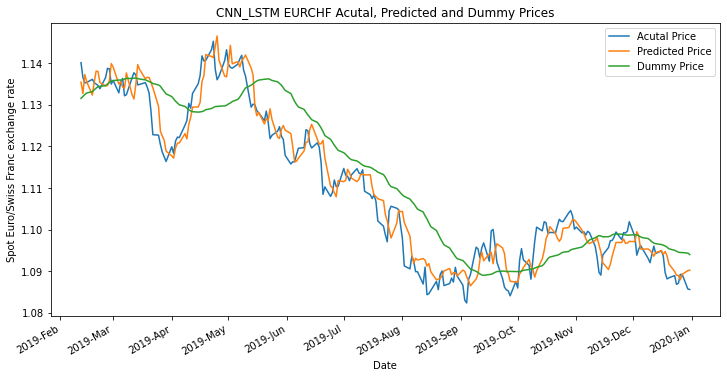

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

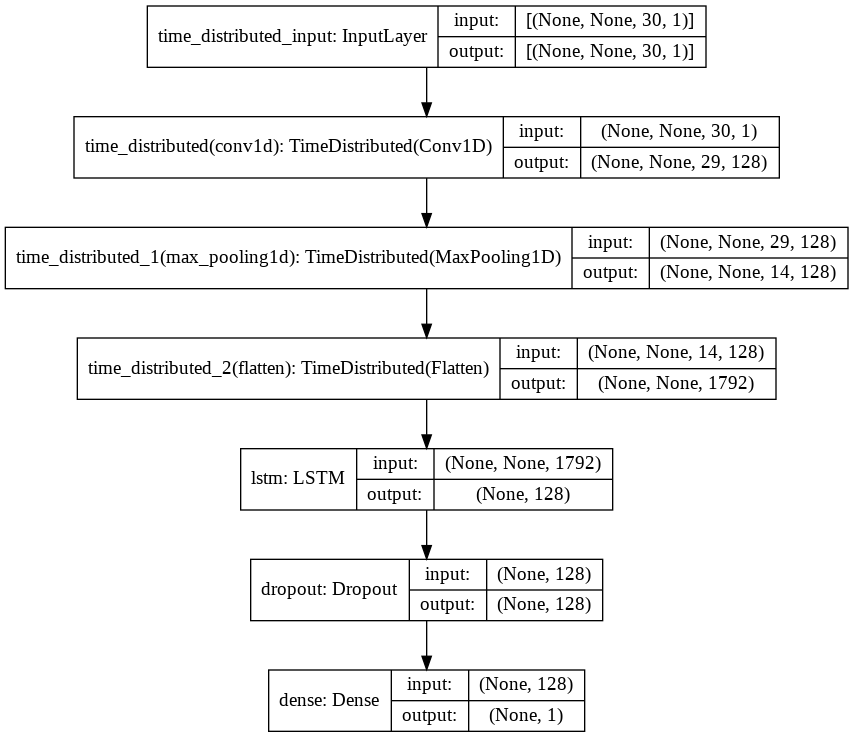

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.004222280844247795
RMSE:  0.0649790800507963
MAE:  0.052007103207563174
Dummy MSE:  0.01696823190684472
Dummy RMSE:  0.13026216606077423
Dummy MAE:  0.10864031818078547


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_LSTM_EURCHF/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_LSTM_EURCHF/assets
